In [4]:
import pandas as pd
import numpy as np
import tempfile
import tensorflow as tf
import pandas as pd

In [5]:
sample_train_pickle = pd.read_pickle('../data_20220831/sample_train_processed_processed.pkl')

In [35]:
sample_train_pickle

,cv_id,jd_id,model_label,age,degree_index_cv,degree_index_jd,degree_match_cvjd,description_tfidf_pca,equal_job,gender_index_cv,...,min_annual_salary,parsed_desiredSalary,position_tfidf_pca,recruit_number,requirement_tfidf_pca,school_intersect_cvjd,title_category_tags_tfidf_pca,workYear,work_duration_mean,workyear_match_cvjd
0,2c9207158059e82b018067f52ee520f1,2c9207157ef60164017ef604e195022e,0,26.0,5,5,1,"[0.0034318132226696, 0.0453854119444269, -0.06...",3,2,...,400.0,180.0,"[0.8020301121767343, 0.4229101266796492, -0.06...",1,"[0.0146099317606446, -0.0973321531897229, -0.0...",1,"[-0.0268220597366096, 0.0146753642354594, -0.1...",4.0,270.00,1
1,2c920715804c9ef601805374e101570a,2c92071580b3a1010180bda0e1166bfd,0,46.0,5,5,1,"[0.0526010120409367, 0.1687600744043454, 0.042...",5,2,...,960.0,360.0,"[0.1703266952313507, -0.0428909764484499, 0.01...",1,"[-0.0804330166663323, -0.265194138646796, 0.05...",1,"[-0.1403481086160699, 0.101545233205827, -0.14...",23.0,1019.50,1
2,2c9207157ef7ed7f017f075fc6640e79,2c9207157d2f0ec5017d5a854c143177,0,36.0,5,5,1,"[-0.0798424978631493, 0.0294367690081744, -0.0...",3,0,...,350.0,360.0,"[-0.0064237143650397, -0.1771169508284544, 0.0...",1,"[-0.0967045533557524, -0.0158876913753405, -0....",0,"[0.0041959442715183, -0.0689690014332659, -0.0...",12.0,832.00,0
3,8a69c4e9824fd55f018258b725082f07,8a69f68e82198e9101822545359e0a0d,0,28.0,5,-3,1,"[0.0953569788219484, -0.1217749783967515, 0.06...",4,0,...,480.0,360.0,"[-0.1512166410895448, 0.039388905830567, -0.01...",1,"[0.1213571418999401, 0.0752965052240779, -0.04...",1,"[0.0593428963865967, -0.0521583781812485, -0.0...",5.0,401.40,1
4,2c920715800e8898018022a768d41cc3,2c9207157f347800017f72dd6e04248b,0,33.0,5,5,1,"[0.0072163480609644, 0.0044387415783859, 0.036...",2,0,...,320.0,360.0,"[0.8020301121767343, 0.4229101266796492, -0.06...",1,"[-0.0555047818278877, -0.0795936243595016, 0.0...",1,"[-0.4085584894502868, 0.2043626298020381, 0.02...",8.0,692.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58499,2c9207157e58b769017e703d68483561,2c9207157dc878e5017ddab2b223521b,1,32.0,2,-3,1,"[-0.0849161155867982, -0.0575842157103247, -0....",0,0,...,96.0,360.0,"[-0.0368041780176452, -0.0857596688737132, -0....",15,"[-0.0668460252602592, 0.0700903434401426, 0.05...",1,"[0.0196958641886768, -0.0692635968080485, -0.0...",8.0,783.50,0
58500,8a69c4e88262c85901826bc2582c33d0,8a69f61482627e7a0182628269db2b56,1,32.0,5,5,1,"[0.0670356722750115, -0.1574484192011676, 0.00...",4,0,...,154.0,270.0,"[-0.1453312134516913, 0.0613943686252203, -0.0...",6,"[-0.0098772535847565, 0.1301945044403502, -0.0...",1,"[0.1167680749390213, -0.0366297624844817, -0.0...",9.0,814.50,1
58501,2c9207157ef7ed7f017f0a990d4d23a0,2c9207157ef7ed16017f0c28fa6c5e48,1,42.0,5,5,1,"[-0.1671116181744903, 0.0182776948093178, 0.15...",4,0,...,480.0,360.0,"[0.0114686317604377, -0.2795560531646292, 0.07...",1,"[-0.097456235834622, -0.0709741819063322, 0.27...",1,"[-0.0871293740917814, -0.0944614800646356, 0.1...",13.0,1141.75,1
58502,8a69d7a68219933d01821fc0c69843ea,2c9207158114fb2901815c03bb257372,1,30.0,5,5,1,"[0.1475688107160124, -0.1547690605224491, 0.02...",4,0,...,280.0,600.0,"[-0.0878304289432486, -0.0431864975598747, -0....",1,"[0.1227189818078986, 0.0444096728787962, -0.01...",1,"[0.1580939681081193, 0.0353872320416606, -0.09...",6.0,501.50,1


In [6]:
sample_test_pickle = pd.read_pickle('../data_20220831/sample_test_processed_processed.pkl')

In [36]:
sample_test_pickle

,cv_id,jd_id,model_label,age,degree_index_cv,degree_index_jd,degree_match_cvjd,description_tfidf_pca,equal_job,gender_index_cv,...,min_annual_salary,parsed_desiredSalary,position_tfidf_pca,recruit_number,requirement_tfidf_pca,school_intersect_cvjd,title_category_tags_tfidf_pca,workYear,work_duration_mean,workyear_match_cvjd
0,2c9207157ef7ed7f017efd02e21e4e49,2c9207157d2f0ec5017d5a7504c72f8b,0,31.0,5,5,1,"[0.05329244438215, 0.2462445696614676, -0.1519...",3,0,...,350.0,360.0,"[0.4348501995964264, -0.0109133937414333, 0.55...",1,"[-0.1419118611278064, -0.1529188641300954, -0....",1,"[-0.2999534601671801, 0.1675461791724773, 0.36...",9.0,1537.500000,1
1,2c920715802399a801804bdec5c34543,2c920715800e886301801791ef1b53ee,0,39.0,6,-3,1,"[-0.1638055912482985, 0.040344238379118, -0.13...",1,0,...,144.0,600.0,"[0.1191989808610592, -0.1764364771607208, -0.1...",1,"[-0.1076417254917609, 0.1969000746662075, 3.28...",1,"[-0.0450986330342915, -0.2783286045295846, -0....",7.0,386.166667,0
2,2c92071581c8d04f0181cb3aa9f4639c,2c92071581c8c61e0181cc4416582615,0,39.0,7,6,1,"[-0.0338068286004353, -0.0899873414587168, -0....",0,0,...,360.0,360.0,"[-0.0368041780176452, -0.0857596688737132, -0....",1,"[-0.0935522486058823, 0.0394952248909006, -0.0...",1,"[0.0088934337229539, -0.0552129385459116, -0.0...",5.0,509.000000,1
3,2c920715802399a801804ba70b163677,2c920715800e886301801791ef1b53ee,0,37.0,5,-3,1,"[-0.1638055912482985, 0.040344238379118, -0.13...",1,1,...,144.0,360.0,"[-0.0187446698414416, -0.166799529429996, -0.0...",1,"[-0.1076417254917609, 0.1969000746662075, 3.28...",1,"[-0.0450986330342915, -0.2783286045295846, -0....",9.0,1461.000000,0
4,2c92071580b3a89c0180d1cdb36c3c4b,2c920715816798cb01817f99f0341751,0,34.0,6,5,1,"[0.0331250095342534, 0.0978827270667928, 0.029...",7,0,...,360.0,840.0,"[0.498600904673763, 0.1642319282921275, 0.0259...",1,"[-0.0296257942655244, -0.095514068279019, -0.2...",1,"[-0.343357678493863, 0.250890015200693, -0.097...",12.0,834.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14622,2c92071581d380c20181ede1f6b4401f,2c92071581d380a00181dccc2ac54686,1,46.0,6,5,1,"[-0.0458930012129997, -0.0966400839575669, -0....",1,0,...,120.0,360.0,"[-0.0387896587140986, -0.1145143770563047, -0....",1,"[-0.0635984771163071, 0.1566419781432294, -0.0...",1,"[0.0292751648590925, -0.0946458180860336, -0.0...",23.0,1564.600000,1
14623,2c9207157dec317f017e0e75e24d4ab8,2c9207157dec2c34017e05671af21551,1,36.0,6,5,1,"[-0.0472408967302047, -0.0540074941140994, -0....",2,1,...,96.0,182.0,"[0.1600138228887109, -0.0082737343539438, -0.0...",1,"[-0.0374584565352739, 0.0564068476779357, 0.04...",1,"[-0.0458219190722429, -0.0389132984183317, -0....",8.0,1156.333333,1
14624,2c92071581d380c20181d7a76b390856,2c92071581cdd33b0181d224cbdf7b06,1,23.0,5,5,1,"[-0.0592506185743158, -0.0655506700028612, 0.1...",2,2,...,195.0,168.0,"[-0.0557137153292651, -0.0853645257508691, -0....",1,"[-0.0930706771115408, -0.0359898261643764, -0....",1,"[-0.0527260069646775, -0.0171684419689047, -0....",3.0,548.000000,1
14625,2c920715816798dd01816b5b135e64b2,2c9207158114fb29018148007d475ade,1,23.0,3,5,0,"[-0.0593055054325864, -0.098314703217636, -0.0...",3,0,...,72.0,84.0,"[-0.0390783810009357, -0.0892115455423144, -0....",1,"[-0.0113261949341071, 0.1086270271668797, 0.00...",1,"[0.0246964705746208, -0.0857444778704595, -0.0...",4.0,426.333333,0


In [7]:
sample_train_pickle.shape

(58504, 25)

In [8]:
sample_test_pickle.shape

(14627, 25)

In [9]:
sample_train_pickle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58504 entries, 0 to 58503
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cv_id                          58504 non-null  object 
 1   jd_id                          58504 non-null  object 
 2   model_label                    58504 non-null  int64  
 3   age                            58504 non-null  float64
 4   degree_index_cv                58504 non-null  int64  
 5   degree_index_jd                58504 non-null  int64  
 6   degree_match_cvjd              58504 non-null  int64  
 7   description_tfidf_pca          58504 non-null  object 
 8   equal_job                      58504 non-null  int64  
 9   gender_index_cv                58504 non-null  int64  
 10  job_intentstatus_cv            58504 non-null  int64  
 11  keyU                           58504 non-null  int64  
 12  kills_tfidf_pca                58504 non-null 

In [10]:
flags = tf.app.flags
FLAGS = flags.FLAGS
tf.app.flags.DEFINE_string('f','','kernel')

flags.DEFINE_string("model_dir", "../modelV0907", "Base directory for output models.") #模型输出路径
flags.DEFINE_integer("train_steps", 100, "Number of training steps.") 


In [11]:
COLUMNS = ['age', 'recruit_number', 'workYear', 'min_annual_salary', 'max_annual_salary', 
            'degree_index_cv', 'degree_index_jd', 'gender_index_cv', 'job_intentstatus_cv',
            'description_tfidf_pca', 'position_tfidf_pca', 'requirement_tfidf_pca', 'kills_tfidf_pca', 'title_category_tags_tfidf_pca',
            'work_duration_mean', 'equal_job', 'parsed_desiredSalary', 'school_intersect_cvjd', 'location_intersect_cvjd',
            'degree_match_cvjd', 'workyear_match_cvjd', 'keyU']

LABEL_COLUMN = "model_label"

# 离散特征
CATEGORICAL_COLUMNS = ['degree_index_cv', 'degree_index_jd', 'gender_index_cv', 'job_intentstatus_cv', 'school_intersect_cvjd',
                        'location_intersect_cvjd', 'degree_match_cvjd', 'workyear_match_cvjd', 'keyU']

# 文本向量特征
ARRAY_COLUMNS = ['description_tfidf_pca', 'position_tfidf_pca', 'requirement_tfidf_pca', 'kills_tfidf_pca', 'title_category_tags_tfidf_pca']

# 连续特征
CONTINUOUS_COLUMNS = ['age', 'recruit_number', 'workYear', 'min_annual_salary', 'max_annual_salary', 
                    'work_duration_mean', 'equal_job', 'parsed_desiredSalary', ]


In [12]:
model_dir = tempfile.mkdtemp() if not '../modelV0907' else '../modelV0907'
print("model dir = %s" % model_dir)

model dir = ../modelV0907


In [13]:
def col2arr(data,col):
    slist = []
    for i in tuple(data.index):
        slist.append(np.array(data.loc[i,col]))
    return np.array(slist)

def input_fn(df):
    continuous_cols = {k: tf.constant(df[k].values) for k in CONTINUOUS_COLUMNS}
    array_cols = {k: tf.constant(col2arr(df,k)) for k in ARRAY_COLUMNS}
    categorical_cols = {k: tf.SparseTensor(indices=[[i,0] for i in range( df[k].size)], values = df[k].values, dense_shape=[df[k].size,1]) for k in CATEGORICAL_COLUMNS}
    
    feature_cols = dict(continuous_cols)
    feature_cols.update(categorical_cols)
    feature_cols.update(array_cols)
    
    label = tf.constant(df[LABEL_COLUMN].values)

    return feature_cols, label

In [14]:
CATEGORICAL_COLUMNS = ['degree_index_cv', 'degree_index_jd', 'gender_index_cv', 'job_intentstatus_cv', 'school_intersect_cvjd',
                        'location_intersect_cvjd', 'degree_match_cvjd', 'workyear_match_cvjd', 'keyU']

# 文本向量特征
ARRAY_COLUMNS = ['description_tfidf_pca', 'position_tfidf_pca', 'requirement_tfidf_pca', 'kills_tfidf_pca', 'title_category_tags_tfidf_pca']

# 连续特征
CONTINUOUS_COLUMNS = ['age', 'recruit_number', 'workYear', 'min_annual_salary', 'max_annual_salary', 
                    'work_duration_mean', 'equal_job', 'parsed_desiredSalary', ]

In [ ]:
'''
tf.feature_column.categorical_column_with_identity(
    key, num_buckets, default_value=None
)
Use this when your inputs are integers in the range [0, num_buckets), 
and you want to use the input value itself as the categorical ID. 
Values outside this range will result in default_value if specified, otherwise it will fail.
'''

In [14]:
# cv的特征一开始是3-10，后来减去了3，变成0-7
# jd的学历特征也减去了3
sample_train_pickle['workyear_match_cvjd'].value_counts()

0    32766
1    25738
Name: workyear_match_cvjd, dtype: int64

In [15]:
sample_train_pickle['title_category_tags_tfidf_pca'][0].__len__()

30

In [16]:
# 将类别特征变成onehot，default_value需要注意
degree_index_cv = tf.feature_column.categorical_column_with_identity('degree_index_cv', num_buckets=8, default_value=0)
degree_index_jd = tf.feature_column.categorical_column_with_identity('degree_index_jd', num_buckets=8, default_value=0)
gender_index_cv = tf.feature_column.categorical_column_with_identity('gender_index_cv', num_buckets=3, default_value=0)
job_intentstatus_cv = tf.feature_column.categorical_column_with_identity('job_intentstatus_cv', num_buckets=4, default_value=0)
school_intersect_cvjd = tf.feature_column.categorical_column_with_identity('school_intersect_cvjd', num_buckets=2, default_value=0)
location_intersect_cvjd = tf.feature_column.categorical_column_with_identity('location_intersect_cvjd', num_buckets=2, default_value=0)
degree_match_cvjd = tf.feature_column.categorical_column_with_identity('degree_match_cvjd', num_buckets=2, default_value=0)
workyear_match_cvjd = tf.feature_column.categorical_column_with_identity('workyear_match_cvjd', num_buckets=2, default_value=0)
keyU = tf.feature_column.categorical_column_with_identity('keyU', num_buckets=2, default_value=0)

# 多维数值特征输入
description_tfidf_pca = tf.feature_column.numeric_column(key="description_tfidf_pca",shape=70)
position_tfidf_pca = tf.feature_column.numeric_column(key="position_tfidf_pca",shape=40)
requirement_tfidf_pca = tf.feature_column.numeric_column(key="requirement_tfidf_pca",shape=70)
kills_tfidf_pca = tf.feature_column.numeric_column(key="kills_tfidf_pca",shape=30)
title_category_tags_tfidf_pca = tf.feature_column.numeric_column(key="title_category_tags_tfidf_pca",shape=30)

# 一维数值特征，还没归一化
age = tf.feature_column.numeric_column("age", default_value=0.0)
recruit_number = tf.feature_column.numeric_column("recruit_number", default_value=0.0)
workYear = tf.feature_column.numeric_column("workYear", default_value=0.0)
min_annual_salary = tf.feature_column.numeric_column("min_annual_salary", default_value=0.0)
max_annual_salary = tf.feature_column.numeric_column("max_annual_salary", default_value=0.0)
work_duration_mean = tf.feature_column.numeric_column("work_duration_mean", default_value=0.0)
equal_job = tf.feature_column.numeric_column("equal_job", default_value=0.0)
parsed_desiredSalary = tf.feature_column.numeric_column("parsed_desiredSalary", default_value=0.0)

# 连续特征分桶onehot
# 连续特征离散化后只会出现在wide侧。
# 思考下：1.哪些特征可以放入wide侧 2.桶的范围
age_buckets = tf.feature_column.bucketized_column(age, boundaries= [18, 25, 30, 35, 40, 45])
recruit_number_buckets = tf.feature_column.bucketized_column(recruit_number, boundaries= [5, 10, 15])
workYear_buckets = tf.feature_column.bucketized_column(workYear, boundaries= [3, 5, 10, 15, 20])
work_duration_mean_buckets = tf.feature_column.bucketized_column(work_duration_mean, boundaries= [365, 547, 730, 1095, 1460])
equal_job_buckets = tf.feature_column.bucketized_column(equal_job, boundaries= [3, 5, 7, 10])
# 还有3个salary特征没有处理


In [17]:
# 类别特征onehot
# 连续数值特征分桶离散化
# 交叉特征
wide_columns = [
                degree_index_cv, degree_index_jd, gender_index_cv, job_intentstatus_cv, 
                school_intersect_cvjd, location_intersect_cvjd, degree_match_cvjd, workyear_match_cvjd, keyU,
                age_buckets, recruit_number_buckets, workYear_buckets, work_duration_mean_buckets, equal_job_buckets,
                tf.feature_column.crossed_column([degree_index_cv, degree_index_jd], hash_bucket_size=int(1e2)),
                tf.feature_column.crossed_column([degree_index_cv, workYear_buckets], hash_bucket_size=int(1e2)),
                tf.feature_column.crossed_column([degree_index_cv, gender_index_cv, age_buckets], hash_bucket_size=int(1e2)),
                tf.feature_column.crossed_column([school_intersect_cvjd, degree_match_cvjd, workyear_match_cvjd, keyU], hash_bucket_size=int(1e2)),
                ]

# 文本向量特征
# 类别特征onehot之后接入embedding层
# 连续的数值特征没有接入
deep_columns = [
                description_tfidf_pca, position_tfidf_pca, requirement_tfidf_pca, kills_tfidf_pca, title_category_tags_tfidf_pca,
                tf.feature_column.embedding_column(degree_index_cv, 8),
                tf.feature_column.embedding_column(degree_index_jd, 8),
                tf.feature_column.embedding_column(gender_index_cv, 8),
                tf.feature_column.embedding_column(school_intersect_cvjd, 8),
                tf.feature_column.embedding_column(location_intersect_cvjd, 8),
                tf.feature_column.embedding_column(degree_match_cvjd, 8),
                tf.feature_column.embedding_column(workyear_match_cvjd, 8),
                tf.feature_column.embedding_column(keyU, 8),
                ]

In [18]:
# 黄金数据集的分位点
percent_list = list(range(1, 10)) 
percent_list.extend([9.5, 9.6, 9.7, 9.8, 9.9, 10])
percent_list = map(lambda x: x*10, percent_list)

# 计算分位点
for percent in percent_list:
    num = np.percentile(sample_train_pickle['work_duration_mean'], percent, interpolation='midpoint')
    print("%{}的分位点是：{}".format(percent, num))

%10的分位点是：425.33333333333326
%20的分位点是：547.0
%30的分位点是：633.2
%40的分位点是：720.3333333333335
%50的分位点是：783.5
%60的分位点是：852.0
%70的分位点是：966.75
%80的分位点是：1116.0
%90的分位点是：1393.9
%95.0的分位点是：1674.5833333333335
%96.0的分位点是：1766.75
%97.0的分位点是：1886.5
%98.0的分位点是：2084.25
%99.0的分位点是：2466.0
%100的分位点是：3624.0


In [19]:
est_config = tf.estimator.RunConfig(
    save_checkpoints_steps = 50,    # Save checkpoints every this many steps. 
    keep_checkpoint_max = 0,       # If None or 0, all checkpoint files are kept. 
)


m = tf.estimator.DNNLinearCombinedClassifier(model_dir=model_dir, 
                                            linear_feature_columns=wide_columns, 
                                            dnn_feature_columns = deep_columns, 
                                            dnn_hidden_units=[200, 100, 30, 10],
                                            config=est_config)

INFO:tensorflow:Using config: {'_model_dir': '../modelV0907', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 50, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 0, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fae1b7afba8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [66]:
m.train(input_fn=lambda: input_fn(sample_train_pickle), steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ../modelV0907/model.ckpt.
INFO:tensorflow:../modelV0907/model.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:loss = 40720.39, step = 1
INFO:tensorflow:Saving checkpoints for 50 into ../modelV0907/model.ckpt.
INFO:tensorflow:../modelV0907/model.ckpt-50 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:Saving checkpoints for 100 into ../modelV0907/model.ckpt.
INFO:tensorflow:../modelV0907/model.ckpt-100 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:global_step/sec: 2.49662
INFO:tensorflow:loss = 34003.176, step = 101 (40.055 sec)
INFO:tensorflow:Saving checkpoints for 150 into ../modelV0907/model.ckpt.
INFO:tensorflow:../mode

In [82]:
results = m.evaluate(input_fn=lambda: input_fn(sample_test_pickle), steps=1, checkpoint_path = '../modelV0907/model.ckpt-100')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-09-07T17:05:32Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../modelV0907/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2022-09-07-17:05:36
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.68763244, accuracy_baseline = 0.570657, auc = 0.74869776, auc_precision_recall = 0.693613, average_loss = 0.5868112, global_step = 100, label/mean = 0.429343, loss = 8583.287, precision = 0.69863015, prediction/mean = 0.40653765, recall = 0.47914013
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: ../modelV0907/model.ckpt-100


In [79]:
results = m.evaluate(input_fn=lambda: input_fn(sample_test_pickle), steps=1, checkpoint_path = '../modelV0907/model.ckpt-500')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-09-07T16:58:57Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../modelV0907/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2022-09-07-16:59:01
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.7284474, accuracy_baseline = 0.570657, auc = 0.79575986, auc_precision_recall = 0.7471512, average_loss = 0.5395019, global_step = 500, label/mean = 0.429343, loss = 7891.2944, precision = 0.7212423, prediction/mean = 0.4145149, recall = 0.59904456
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: ../modelV0907/model.ckpt-500


In [80]:
results = m.evaluate(input_fn=lambda: input_fn(sample_test_pickle), steps=1, checkpoint_path = '../modelV0907/model.ckpt-1000')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2022-09-07T16:59:29Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../modelV0907/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2022-09-07-16:59:33
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.7446503, accuracy_baseline = 0.570657, auc = 0.8170671, auc_precision_recall = 0.773738, average_loss = 0.5155848, global_step = 1000, label/mean = 0.429343, loss = 7541.4595, precision = 0.73174286, prediction/mean = 0.41370174, recall = 0.6398089
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: ../modelV0907/model.ckpt-1000


In [81]:
results

{'accuracy': 0.7446503,
 'accuracy_baseline': 0.570657,
 'auc': 0.8170671,
 'auc_precision_recall': 0.773738,
 'average_loss': 0.5155848,
 'label/mean': 0.429343,
 'loss': 7541.4595,
 'precision': 0.73174286,
 'prediction/mean': 0.41370174,
 'recall': 0.6398089,
 'global_step': 1000}

In [84]:
p = m.predict(input_fn=lambda: input_fn(sample_test_pickle), checkpoint_path = '../modelV0907/model.ckpt-1000')

In [85]:
count = 0
pred = []
for i in p:
    if count == len(sample_test_pickle):
        break
    # i是一个字典
    pred.append(i['probabilities'])
    count += 1

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../modelV0907/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [86]:
pred_label = pd.DataFrame(pred)
pred_label

,0,1
0,0.877076,0.122924
1,0.982511,0.017489
2,0.200850,0.799150
3,0.928102,0.071898
4,0.910424,0.089576
...,...,...
14622,0.182305,0.817695
14623,0.238755,0.761245
14624,0.303029,0.696971
14625,0.060288,0.939712


In [87]:
real_label = sample_test_pickle[['model_label']]
real_label

,model_label
0,0
1,0
2,0
3,0
4,0
...,...
14622,1
14623,1
14624,1
14625,1


0.8171


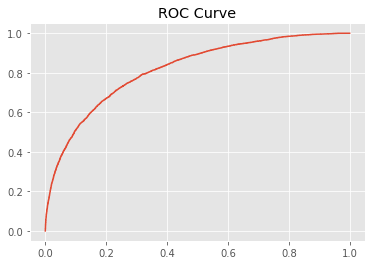

In [89]:
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plot
from sklearn.metrics import auc

y = np.array(real_label['model_label'])
scores = np.array(pred_label[1])

fpr, tpr, thresholds = metrics.roc_curve(y, scores)
AUC = round(auc(fpr, tpr), 4)
print(AUC)
plot.figure("ROC Curve")
plot.title("ROC Curve")
plot.xlabel = ('FPR')
plot.ylabel = ('TPR')
plot.plot(fpr, tpr, label='ROC')
plot.show()


In [90]:
pred_real_label = pd.concat([pred_label[[0,1]], real_label], axis=1)
pred_real_label

,0,1,model_label
0,0.877076,0.122924,0
1,0.982511,0.017489,0
2,0.200850,0.799150,0
3,0.928102,0.071898,0
4,0.910424,0.089576,0
...,...,...,...
14622,0.182305,0.817695,1
14623,0.238755,0.761245,1
14624,0.303029,0.696971,1
14625,0.060288,0.939712,1


In [91]:
# 过滤出label等于0的数据
pred_real_label_0 = pred_real_label[pred_real_label['model_label']==0].reset_index(drop=True)
pred_real_label_0

,0,1,model_label
0,0.877076,0.122924,0
1,0.982511,0.017489,0
2,0.200850,0.799150,0
3,0.928102,0.071898,0
4,0.910424,0.089576,0
...,...,...,...
8342,0.839830,0.160170,0
8343,0.727290,0.272710,0
8344,0.616401,0.383599,0
8345,0.400818,0.599182,0


In [92]:
# 过滤出label等于1的数据
pred_real_label_1 = pred_real_label[pred_real_label['model_label']==1].reset_index(drop=True)
pred_real_label_1

,0,1,model_label
0,0.575839,0.424161,1
1,0.274596,0.725404,1
2,0.305620,0.694380,1
3,0.591284,0.408716,1
4,0.062814,0.937186,1
...,...,...,...
6275,0.182305,0.817695,1
6276,0.238755,0.761245,1
6277,0.303029,0.696971,1
6278,0.060288,0.939712,1


In [3]:
import pandas as pd

rerec_data_pickle = pd.read_pickle('../data_20220831/sample_rerec_data_processed_processed.pkl')
rerec_data_pickle
# 这个rerec_data_pickle是经过过滤的，所以index不连续

,cv_id,jd_id,model_label,age,degree_index_cv,degree_index_jd,degree_match_cvjd,description_tfidf_pca,equal_job,gender_index_cv,...,min_annual_salary,parsed_desiredSalary,position_tfidf_pca,recruit_number,requirement_tfidf_pca,school_intersect_cvjd,title_category_tags_tfidf_pca,workYear,work_duration_mean,workyear_match_cvjd
0,2c92071580f6d9840180ffea3ae70284,2c9207157ef7ed16017efb6696353b11,0,28.0,5,5,1,"[0.213528299923103, 0.278360176354237, 0.10116...",2,1,...,560.0,420.0,"[-0.03490806639846, -0.0948244005230921, -0.04...",1,"[-0.1286863059399647, -0.2703918780581468, -0....",1,"[-0.2265948554965031, 0.2365975687445597, -0.2...",5.0,608.666667,1
1,2c92071580f6d9840180ffea3ae70284,2c9207157ef7ed16017efca7c41522cf,0,28.0,5,5,1,"[0.213528299923103, 0.278360176354237, 0.10116...",2,1,...,420.0,420.0,"[-0.03490806639846, -0.0948244005230921, -0.04...",1,"[-0.1286863059399647, -0.2703918780581468, -0....",1,"[-0.2468591407567025, 0.3630902466565336, -0.3...",5.0,608.666667,1
2,2c920715811ee1b901814751c8d575b4,2c9207157fbc99ce017fcfba4b353e48,0,29.0,6,5,1,"[-0.0458930012129997, -0.0966400839575669, -0....",2,0,...,240.0,650.0,"[0.8020301121767343, 0.4229101266796492, -0.06...",1,"[-0.0635984771163071, 0.1566419781432294, -0.0...",1,"[-0.3690522371769096, 0.4612123417733267, -0.5...",5.0,898.000000,0
3,2c920715811ee1b901814751c8d575b4,2c92071581c8c61e0181cd2af3a41fc1,0,29.0,6,5,1,"[0.1730058508436928, 0.1418203394591635, 0.034...",2,0,...,240.0,650.0,"[0.8020301121767343, 0.4229101266796492, -0.06...",1,"[-0.0579456853457267, -0.0713339990256664, -0....",1,"[-0.2235705077862443, 0.3357177304447382, -0.3...",5.0,898.000000,1
4,2c92071581afaf4b0181b7caff713c2e,2c92071581900df30181951e9e0566b9,0,36.0,6,5,1,"[-0.0278806081579946, -0.1170904123376754, -0....",2,1,...,375.0,450.0,"[-0.0876980561444726, -0.0290344942161584, -0....",1,"[0.0394637124870746, 0.0977519032852919, -0.04...",1,"[0.054213895114271, -0.0531060478281485, -0.03...",12.0,751.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764,2c920715811ee1b9018122634ef40a0c,2c9207158114fb29018123914662667b,0,32.0,4,5,0,"[-0.1164895971599631, 0.2985907324720861, 0.01...",0,2,...,360.0,420.0,"[-0.0370250470088169, -0.0866356676886159, -0....",1,"[-0.1012095218088791, -0.0520556537111129, -0....",1,"[-0.334069116493843, 0.1818655978459128, 0.489...",7.0,487.400000,1
2765,2c9207158160d6c3018161bc3acb30a6,2c9207158114fb2901814111cda42dc7,0,31.0,6,5,1,"[0.2585656897511508, 0.2372366511374906, -0.07...",4,2,...,420.0,420.0,"[-0.0425010862013197, -0.0826814066269554, -0....",1,"[-0.0598641958745639, -0.0831534918677584, -0....",1,"[0.0031251855626012, -0.0372985562817497, -0.0...",8.0,852.333333,0
2766,2c9207158059e82b0180776b26675c63,2c920715800e886301802080134114c6,0,33.0,5,5,1,"[0.3037023595523817, 0.0681411549333817, 0.081...",1,0,...,350.0,420.0,"[-0.1184344831268608, 0.0076050251503756, -0.0...",1,"[0.1724390256084213, 0.120637276861982, 0.0191...",1,"[0.0954174343329668, 0.014156893281137, -0.018...",7.0,2527.000000,1
2767,2c920715811ee1b901813bb4a108323e,2c9207158114fb290181411575a132c7,0,31.0,6,5,1,"[0.1328676844535005, 0.035811877537902, 0.0223...",0,2,...,420.0,420.0,"[-0.0368041780176452, -0.0857596688737132, -0....",30,"[-0.0548999540439312, -0.1093718677773959, -0....",1,"[0.0314784058595657, -0.090467903967384, -0.05...",7.0,751.000000,1


In [39]:
rerec_data_pickle = rerec_data_pickle.reset_index(drop=True)

In [40]:
rerec_data_pickle

,cv_id,jd_id,model_label,age,degree_index_cv,degree_index_jd,degree_match_cvjd,description_tfidf_pca,equal_job,gender_index_cv,...,min_annual_salary,parsed_desiredSalary,position_tfidf_pca,recruit_number,requirement_tfidf_pca,school_intersect_cvjd,title_category_tags_tfidf_pca,workYear,work_duration_mean,workyear_match_cvjd
0,2c92071580f6d9840180ffea3ae70284,2c9207157ef7ed16017efb6696353b11,0,28.0,5,5,1,"[0.213528299923103, 0.278360176354237, 0.10116...",2,1,...,560.0,420.0,"[-0.03490806639846, -0.0948244005230921, -0.04...",1,"[-0.1286863059399647, -0.2703918780581468, -0....",1,"[-0.2265948554965031, 0.2365975687445597, -0.2...",5.0,608.666667,1
1,2c92071580f6d9840180ffea3ae70284,2c9207157ef7ed16017efca7c41522cf,0,28.0,5,5,1,"[0.213528299923103, 0.278360176354237, 0.10116...",2,1,...,420.0,420.0,"[-0.03490806639846, -0.0948244005230921, -0.04...",1,"[-0.1286863059399647, -0.2703918780581468, -0....",1,"[-0.2468591407567025, 0.3630902466565336, -0.3...",5.0,608.666667,1
2,2c920715811ee1b901814751c8d575b4,2c9207157fbc99ce017fcfba4b353e48,0,29.0,6,5,1,"[-0.0458930012129997, -0.0966400839575669, -0....",2,0,...,240.0,650.0,"[0.8020301121767343, 0.4229101266796492, -0.06...",1,"[-0.0635984771163071, 0.1566419781432294, -0.0...",1,"[-0.3690522371769096, 0.4612123417733267, -0.5...",5.0,898.000000,0
3,2c920715811ee1b901814751c8d575b4,2c92071581c8c61e0181cd2af3a41fc1,0,29.0,6,5,1,"[0.1730058508436928, 0.1418203394591635, 0.034...",2,0,...,240.0,650.0,"[0.8020301121767343, 0.4229101266796492, -0.06...",1,"[-0.0579456853457267, -0.0713339990256664, -0....",1,"[-0.2235705077862443, 0.3357177304447382, -0.3...",5.0,898.000000,1
4,2c92071581afaf4b0181b7caff713c2e,2c92071581900df30181951e9e0566b9,0,36.0,6,5,1,"[-0.0278806081579946, -0.1170904123376754, -0....",2,1,...,375.0,450.0,"[-0.0876980561444726, -0.0290344942161584, -0....",1,"[0.0394637124870746, 0.0977519032852919, -0.04...",1,"[0.054213895114271, -0.0531060478281485, -0.03...",12.0,751.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2722,2c920715811ee1b9018122634ef40a0c,2c9207158114fb29018123914662667b,0,32.0,4,5,0,"[-0.1164895971599631, 0.2985907324720861, 0.01...",0,2,...,360.0,420.0,"[-0.0370250470088169, -0.0866356676886159, -0....",1,"[-0.1012095218088791, -0.0520556537111129, -0....",1,"[-0.334069116493843, 0.1818655978459128, 0.489...",7.0,487.400000,1
2723,2c9207158160d6c3018161bc3acb30a6,2c9207158114fb2901814111cda42dc7,0,31.0,6,5,1,"[0.2585656897511508, 0.2372366511374906, -0.07...",4,2,...,420.0,420.0,"[-0.0425010862013197, -0.0826814066269554, -0....",1,"[-0.0598641958745639, -0.0831534918677584, -0....",1,"[0.0031251855626012, -0.0372985562817497, -0.0...",8.0,852.333333,0
2724,2c9207158059e82b0180776b26675c63,2c920715800e886301802080134114c6,0,33.0,5,5,1,"[0.3037023595523817, 0.0681411549333817, 0.081...",1,0,...,350.0,420.0,"[-0.1184344831268608, 0.0076050251503756, -0.0...",1,"[0.1724390256084213, 0.120637276861982, 0.0191...",1,"[0.0954174343329668, 0.014156893281137, -0.018...",7.0,2527.000000,1
2725,2c920715811ee1b901813bb4a108323e,2c9207158114fb290181411575a132c7,0,31.0,6,5,1,"[0.1328676844535005, 0.035811877537902, 0.0223...",0,2,...,420.0,420.0,"[-0.0368041780176452, -0.0857596688737132, -0....",30,"[-0.0548999540439312, -0.1093718677773959, -0....",1,"[0.0314784058595657, -0.090467903967384, -0.05...",7.0,751.000000,1


In [41]:
p = m.predict(input_fn=lambda: input_fn(rerec_data_pickle), checkpoint_path = '../modelV0907/model.ckpt-1000')

In [42]:
count = 0
pred = []
for i in p:
    if count == len(rerec_data_pickle):
        break
    # i是一个字典
    pred.append(i['probabilities'])
    count += 1

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../modelV0907/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [43]:
pred_label = pd.DataFrame(pred)
pred_label

,0,1
0,0.110490,0.889510
1,0.186307,0.813693
2,0.644227,0.355773
3,0.727438,0.272562
4,0.355596,0.644404
...,...,...
2722,0.169411,0.830589
2723,0.585148,0.414852
2724,0.138266,0.861734
2725,0.171602,0.828398


In [44]:
real_label = rerec_data_pickle[['model_label']]
real_label

,model_label
0,0
1,0
2,0
3,0
4,0
...,...
2722,0
2723,0
2724,0
2725,0


In [47]:
pred_real_label = pd.concat([pred_label[[0,1]], real_label], axis=1)
pred_real_label

,0,1,model_label
0,0.110490,0.889510,0
1,0.186307,0.813693,0
2,0.644227,0.355773,0
3,0.727438,0.272562,0
4,0.355596,0.644404,0
...,...,...,...
2722,0.169411,0.830589,0
2723,0.585148,0.414852,0
2724,0.138266,0.861734,0
2725,0.171602,0.828398,0


In [61]:
pred_real_label['model_label'].value_counts()

0    2697
1      30
Name: model_label, dtype: int64

In [63]:
# 过滤出label等于0的数据
pred_real_label_0 = pred_real_label[pred_real_label['model_label']==0].reset_index(drop=True)
pred_real_label_0

,0,1,model_label
0,0.110490,0.889510,0
1,0.186307,0.813693,0
2,0.644227,0.355773,0
3,0.727438,0.272562,0
4,0.355596,0.644404,0
...,...,...,...
2692,0.169411,0.830589,0
2693,0.585148,0.414852,0
2694,0.138266,0.861734,0
2695,0.171602,0.828398,0


In [65]:
# 过滤出label等于1的数据
pred_real_label_1 = pred_real_label[pred_real_label['model_label']==1].reset_index(drop=True)
pred_real_label_1

,0,1,model_label
0,0.864245,0.135755,1
1,0.582286,0.417714,1
2,0.458089,0.541911,1
3,0.801918,0.198082,1
4,0.348937,0.651063,1
5,0.122732,0.877268,1
6,0.281803,0.718197,1
7,0.807998,0.192001,1
8,0.247520,0.752480,1
9,0.899914,0.100086,1


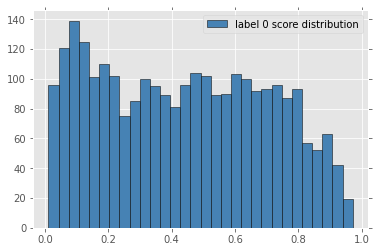

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# label 0的score
data = pred_real_label_0[1]

plt.style.use('ggplot')
plt.hist(data, # 绘图数据
        bins = 30, # 指定直方图的条形数为30个
        color = 'steelblue', # 指定填充色
        edgecolor = 'k', # 指定直方图的边界色
        label = 'label 0 score distribution' )# 为直方图呈现标签

plt.tick_params(top='off', right='off')
plt.legend()
plt.show()


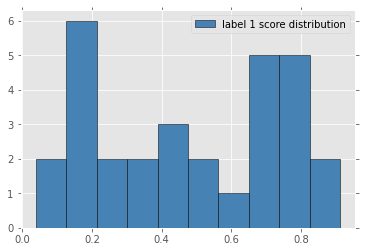

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# label 0的score
data = pred_real_label_1[1]

plt.style.use('ggplot')
plt.hist(data, # 绘图数据
        bins = 10, # 指定直方图的条形数为10个
        color = 'steelblue', # 指定填充色
        edgecolor = 'k', # 指定直方图的边界色
        label = 'label 1 score distribution' )# 为直方图呈现标签

plt.tick_params(top='off', right='off')
plt.legend()
plt.show()


AttributeError: 'Rectangle' object has no property 'normed'

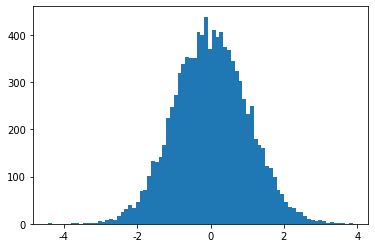

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# 设置matplotlib正常显示中文和负号
matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号
# 随机生成（10000,）服从正态分布的数据
data = np.random.randn(10000)
"""
绘制直方图
data:必选参数，绘图数据
bins:直方图的长条形数目，可选项，默认为10
normed:是否将得到的直方图向量归一化，可选项，默认为0，代表不归一化，显示频数。normed=1，表示归一化，显示频率。
facecolor:长条形的颜色
edgecolor:长条形边框的颜色
alpha:透明度
"""
plt.hist(data, bins=80, normed=0, facecolor="blue", edgecolor="black", alpha=0)
# 显示横轴标签
plt.xlabel("区间")
# 显示纵轴标签
plt.ylabel("频数/频率")
# 显示图标题
plt.title("频数/频率分布直方图")
plt.show()